# Graph-UNets

Hereafter is the implementation of the paper https://arxiv.org/pdf/1905.05178v1.pdf, this is indeed the method chosen from the ones listed in the survey paper https://arxiv.org/pdf/2110.05292.pdf

To summarize the approach we composed a UNet, with its characteristical skip connections, after which we simply inserted a linear layer. Such topping allowed us to adoperate a method widely adopted for generation tasks to exploit it for graph classification.

In this experiment we adopted GeneralConv as convolutional layer instead of GCNConv.
This library was found after a through search among those adopted as convolutional layers for graph.  
GeneralConv has the possibility of performing attention during the convolution, and even multi-head attention, together with several other optional extra features.  
Attention in general has proven to often boost performances.

## Imports

In [1]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from tqdm import tqdm
from torch import nn
from torch_geometric.nn import GCNConv,TopKPooling,global_mean_pool, GraphConv, GeneralConv
from torch_geometric import seed_everything
from torch_geometric.utils.convert import to_scipy_sparse_matrix
from torch_geometric.utils.sparse import dense_to_sparse,to_torch_coo_tensor
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

## Dataset

For our experiment we picked the PROTEINS dataset, which is one of those selected in the Graph-UNets paper.  
The dataset was divided as such:
- 81% for the training set
- 9% for the validation set
- 10 % for the test set

In [2]:
seed_everything(77) #Seed for all random actions, this library is a proxy for other libraries, e.g. pytorch
path=""
dataset = TUDataset(path, name='PROTEINS').shuffle() #Here we shuffle the dataset to break any potential order correlation

print("Dataset is undirected? ", dataset[0].is_undirected()) #This is a vital information!
print ("Len of dataset: ", len(dataset))
train_set = dataset[:int(0.9*len(dataset))]
train_dataset = train_set[:int(0.9*len(train_set))]
val_dataset = train_set[int(0.9*len(train_set)):]
test_dataset = dataset[int(0.9*len(dataset)):]
print("Len of train dataset: ", len(train_dataset))
print("Len of validation dataset: ",len(val_dataset))
print("Len of test dataset: ",len(test_dataset))

batch_size=128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Extracting .\PROTEINS\PROTEINS.zip
Processing...


Dataset is undirected?  True
Len of dataset:  1113
Len of train dataset:  900
Len of validation dataset:  101
Len of test dataset:  112


Done!


## Graph Pooling

![title](graphpool.png)

In [3]:
class gPool(nn.Module):
    """
    Our implementation of the pooling methodology described in the paper, above you can see the pseudocode
    """
    def __init__(self,in_dim,ratio):
        super().__init__()
        self.in_dim=in_dim
        self.ratio=ratio
        self.p=nn.Linear(in_dim,1)
        self.sigmoid=nn.Sigmoid()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def forward(self,xl,edge_index):
        
        #y is described as a learnable projection, hence we estimated a linear layer to be a suitable choice
        
        y=self.p(xl) #/torch.norm(self.p(xl)) #DO WE HAVE TO INSERT THE NORM?
        
        k=int(self.ratio*len(y))#Number of selected nodes, the k in TopkPooling
        
        topks, idx =torch.topk(y,k,dim=0) #The k elements with top scores, and their corresponding idx
        
        y_hat=self.sigmoid(topks)
        xl_hat=xl[idx,:].squeeze() #Feature matrix of topk nodes
        xl1=xl_hat * y_hat  #Gate operation
        
        al = torch.as_tensor(to_scipy_sparse_matrix(edge_index,num_nodes=len(y)).todense(), device = self.device)
        al1 = torch.index_select(torch.as_tensor(al),0,idx.squeeze()) #no direct indexing because of ram overloading
        al1=torch.index_select(al1,1,idx.squeeze())
        sparsel1=dense_to_sparse(al1)
        edge_index_pooled=torch.sparse_coo_tensor(sparsel1[0],sparsel1[1]).coalesce().indices() #Our model elaborates coo tensors
        return xl1, edge_index_pooled, idx.squeeze()

In [4]:
"""
Simple example to prove that dim=0 in the norm is not equal for all inputs, depends on the dimension
p=nn.Linear(4,1)
xl=torch.ones((6,4))
y=p(xl)/torch.norm(p(xl))
xl2=torch.ones((2,4))
print(torch.norm(p(xl),dim=0))
print(torch.norm(p(xl2),dim=0))
"""

'\nSimple example to prove that dim=0 in the norm is not equal for all inputs, depends on the dimension\np=nn.Linear(4,1)\nxl=torch.ones((6,4))\ny=p(xl)/torch.norm(p(xl))\nxl2=torch.ones((2,4))\nprint(torch.norm(p(xl),dim=0))\nprint(torch.norm(p(xl2),dim=0))\n'

## Graph Unpooling

In [5]:
class gUnpool(nn.Module):
    """
    Our implementation of the unpooling methodology described in the paper
    """
    def __init__(self,in_dim,out_dim):
        super().__init__()
        self.in_dim=in_dim
        self.out_dim=out_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def forward(self,xl,idx,up_shape):
        up_nodes,C = up_shape #We extract the number of nodes and features the graph has to return to
        xl1=torch.zeros((up_nodes,xl.shape[1]), device = self.device)
        xl1[idx]=xl #We fetch the current feature matrix and sorround it of zeros to have the desired shape
        return xl1
        

## U-Net

The U-Net as described in the paper, below is the graphical representation in the paper, however the number of up and down blocks is inferior with respect to the paper description, which is four upblocks and four downblocks as presented in the code below.

![title](unet_structure.png)

In [6]:
class UNet(nn.Module):
    def __init__(self, improved = False, dropout = 0.3 ):
        super().__init__()
        self.in_conv = GeneralConv(dataset.num_features, 16, directed_msg = False,heads = 8,attention= True, attention_type= 'dot_product')
        #heads = 4, 
        #attention= False
        #l2_normalize= False
        
        self.GC1 =GeneralConv(16, 32, directed_msg = False,heads = 8, attention= True, attention_type= 'dot_product')
        self.GC2 =GeneralConv(32, 64,  directed_msg = False,heads = 8, attention= True, attention_type= 'dot_product')
        self.GC3 =GeneralConv(64, 128,  directed_msg = False,heads = 8, attention= True, attention_type= 'dot_product')
        self.GC4 =GeneralConv(128, 256,  directed_msg = False,heads = 8, attention= True, attention_type= 'dot_product')
        self.act=nn.LeakyReLU()
        
        self.gPool1 = gPool(16, 0.9)
        self.gPool2 = gPool(32, 0.7)
        self.gPool3 = gPool(64, 0.6)
        self.gPool4 = gPool(128, 0.5)
        
        self.gUnpool1 = gUnpool(256, 128)
        self.gUnpool2 = gUnpool(128, 64)
        self.gUnpool3 = gUnpool(64, 32)
        self.gUnpool4 = gUnpool(32, 16)
        
        self.GC5 = GeneralConv(256+128, 128, directed_msg = False, heads = 8, attention= True, attention_type= 'dot_product')
        self.GC6 = GeneralConv(128+64, 64, directed_msg = False,heads = 8, attention= True,  attention_type= 'dot_product')
        self.GC7 = GeneralConv(64+32, 32, directed_msg = False,heads = 8, attention= True,  attention_type= 'dot_product')
        self.GC8 = GeneralConv(32+16, 16, directed_msg = False,heads = 8, attention= True, attention_type= 'dot_product')
        
        self.out_conv = GeneralConv(16, dataset.num_features, directed_msg = False,heads = 8, attention= True, attention_type= 'dot_product')
        
        self.linear = nn.Linear(dataset.num_features, 1)
        
    
    def forward(self,x,edge_index,batch):
        x1 = self.in_conv(x, edge_index)
        x1 = self.act(x1)
        
        # Encoder
        
        #Pool1
        x2, edge_index2, idx2 = self.gPool1(x1,edge_index)
        x2 = self.act(x2)
        
        x3 = self.GC1(x2, edge_index2)
        x3 = self.act(x3)
        
        #Pool2
        x4,  edge_index4, idx4 = self.gPool2(x3,edge_index2)
        x4 = self.act(x4)
        
        x5 = self.GC2(x4, edge_index4)
        x5 = self.act(x5)
        
        #Pool3
        x6,  edge_index6, idx6 = self.gPool3(x5,edge_index4)
        x6 = self.act(x6)
        
        x7 = self.GC3(x6, edge_index6)
        x7 = self.act(x7)
        
        #Pool4
        x8,  edge_index8, idx8 = self.gPool4(x7,edge_index6)
        x8 = self.act(x8)
        
        x9 = self.GC4(x8, edge_index8)
        x9 = self.act(x9)
        
        #Decoder
        
        #Unpool1
        x10 = self.gUnpool1(x9,idx8,x7.shape)
        x10 = torch.cat([x7, x10], dim=1) #Skip connection, an alternative would be to use the sum, i.e. #x10 = x7 + x10
        x10 = self.act(x10)
        
        x11 = self.GC5(x10, edge_index8)
        x11 = self.act(x11)
        
        #Unpool2
        x12 = self.gUnpool2(x11,idx6,x5.shape)
        x12 = torch.cat([x5, x12], dim=1)
        x12 = self.act(x12)
        
        x13 = self.GC6(x12, edge_index6)
        x13 = self.act(x13)
        
        #Unpool3
        x14 = self.gUnpool3(x13,idx4,x3.shape)
        x14 = torch.cat([x3, x14], dim=1)
        x14 = self.act(x14)
        
        x15 = self.GC7(x14, edge_index4)
        x15 = self.act(x15)
        
        #Unpool4
        x16 = self.gUnpool4(x15,idx2,x1.shape)
        x16 = torch.cat([x1, x16], dim=1)
        x16 = self.act(x16)
        
        x17 = self.GC8(x16, edge_index2)
        x17 = self.act(x17)
        
        
        x18 = self.out_conv(x17, edge_index)
        x18 = self.act(x18)
        
        #Readout
        x19 = global_mean_pool(x18, batch) #readout layer commonly adoperated - reference: https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=CN3sRVuaQ88l
        x19 = self.act(x19)
        
        #Linear
        x19=self.linear(x19)
        
        return x19

## Parameters customization

In [7]:
seed_everything(77)
lrate =0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=UNet().to(device) #Customize the model by changing these parameters

optimizer = torch.optim.Adam(model.parameters(), lr=lrate) #Adam because it is adaptive
criterion=nn.BCEWithLogitsLoss()
sigmoid=nn.Sigmoid()
epochs=200

## Training

Here we start the training of the model, we perform one epoch on the training set and one on the validation set.

In [8]:
seed_everything(77)
train_losses=[]
val_losses=[]
train_accuracies=[]
val_accuracies=[]
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_acc=0.0
    for i, data in enumerate(tqdm(train_loader)):
        data = data.to(device) #E.g. DataBatch(edge_index=[2, 19062], x=[5024, 3], y=[128], batch=[5024], ptr=[129])
        optimizer.zero_grad()
        pred = model(data.x, data.edge_index, data.batch)
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        loss.backward()
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        train_acc+=acc
        train_loss += loss.item()
        optimizer.step()
        
    epoch_train_loss=train_loss/len(train_loader) #We compute the average train loss for each epoch
    train_losses.append(epoch_train_loss)
    epoch_train_accuracy=train_acc/len(train_loader) #We compute the average train accuracy for each epoch
    train_accuracies.append(epoch_train_accuracy)
    print(f"Training loss epoch {epoch}: ", epoch_train_loss)
    print(f"Training accuracy epoch {epoch}: ", epoch_train_accuracy)
    
    model.eval()
    val_loss = 0.0
    val_acc=0.0
    for i, data in enumerate(tqdm(val_loader)):
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch)
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        val_acc+=acc
        val_loss += loss.item()
    
    epoch_val_loss=val_loss/len(val_loader) #We compute the average train loss for each epoch
    val_losses.append(epoch_val_loss)
    epoch_val_accuracy=val_acc/len(val_loader) #We compute the average train accuracy for each epoch
    val_accuracies.append(epoch_val_accuracy)
    print(f"Validation loss epoch {epoch}: ", epoch_val_loss)
    print(f"Validation accuracy epoch {epoch}: ", epoch_val_accuracy)
print('Finished Training')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.04it/s]


Training loss epoch 0:  0.6783813834190369
Training accuracy epoch 0:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.76it/s]


Validation loss epoch 0:  0.6807764768600464
Validation accuracy epoch 0:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.30it/s]


Training loss epoch 1:  0.6878919899463654
Training accuracy epoch 1:  0.5615234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.51it/s]


Validation loss epoch 1:  0.6788370609283447
Validation accuracy epoch 1:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.41it/s]


Training loss epoch 2:  0.6647288128733635
Training accuracy epoch 2:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.45it/s]


Validation loss epoch 2:  0.6749487519264221
Validation accuracy epoch 2:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.14it/s]


Training loss epoch 3:  0.6442982628941536
Training accuracy epoch 3:  0.6533203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.67it/s]


Validation loss epoch 3:  0.6670936942100525
Validation accuracy epoch 3:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.81it/s]


Training loss epoch 4:  0.662292368710041
Training accuracy epoch 4:  0.5966796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


Validation loss epoch 4:  0.6443470120429993
Validation accuracy epoch 4:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.05it/s]


Training loss epoch 5:  0.6210168786346912
Training accuracy epoch 5:  0.6689453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


Validation loss epoch 5:  0.6600709557533264
Validation accuracy epoch 5:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.87it/s]


Training loss epoch 6:  0.6517004072666168
Training accuracy epoch 6:  0.5947265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.40it/s]


Validation loss epoch 6:  0.6384696960449219
Validation accuracy epoch 6:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.69it/s]


Training loss epoch 7:  0.6771343871951103
Training accuracy epoch 7:  0.603515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.10it/s]


Validation loss epoch 7:  0.6538630723953247
Validation accuracy epoch 7:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.03it/s]


Training loss epoch 8:  0.6408327966928482
Training accuracy epoch 8:  0.6298828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.57it/s]


Validation loss epoch 8:  0.6513609886169434
Validation accuracy epoch 8:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.16it/s]


Training loss epoch 9:  0.6566083654761314
Training accuracy epoch 9:  0.61328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.25it/s]


Validation loss epoch 9:  0.6457929611206055
Validation accuracy epoch 9:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.66it/s]


Training loss epoch 10:  0.6221228092908859
Training accuracy epoch 10:  0.69921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]


Validation loss epoch 10:  0.6168473958969116
Validation accuracy epoch 10:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.58it/s]


Training loss epoch 11:  0.5939445197582245
Training accuracy epoch 11:  0.7119140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


Validation loss epoch 11:  0.6410191655158997
Validation accuracy epoch 11:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


Training loss epoch 12:  0.6234748587012291
Training accuracy epoch 12:  0.6826171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.44it/s]


Validation loss epoch 12:  0.6235759854316711
Validation accuracy epoch 12:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


Training loss epoch 13:  0.7201314717531204
Training accuracy epoch 13:  0.6533203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


Validation loss epoch 13:  0.632027804851532
Validation accuracy epoch 13:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.39it/s]


Training loss epoch 14:  0.6147004254162312
Training accuracy epoch 14:  0.705078125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]


Validation loss epoch 14:  0.6470382213592529
Validation accuracy epoch 14:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.34it/s]


Training loss epoch 15:  0.6626006960868835
Training accuracy epoch 15:  0.6083984375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.98it/s]


Validation loss epoch 15:  0.654810905456543
Validation accuracy epoch 15:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.87it/s]


Training loss epoch 16:  0.6432169005274773
Training accuracy epoch 16:  0.5927734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


Validation loss epoch 16:  0.6512851715087891
Validation accuracy epoch 16:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.05it/s]


Training loss epoch 17:  0.6335263550281525
Training accuracy epoch 17:  0.6279296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.32it/s]


Validation loss epoch 17:  0.6319702863693237
Validation accuracy epoch 17:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.79it/s]


Training loss epoch 18:  0.6146785542368889
Training accuracy epoch 18:  0.685546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.77it/s]


Validation loss epoch 18:  0.620869517326355
Validation accuracy epoch 18:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.77it/s]


Training loss epoch 19:  0.6070702597498894
Training accuracy epoch 19:  0.6845703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.73it/s]


Validation loss epoch 19:  0.6200498342514038
Validation accuracy epoch 19:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.09it/s]


Training loss epoch 20:  0.6407256796956062
Training accuracy epoch 20:  0.6640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.54it/s]


Validation loss epoch 20:  0.6200761795043945
Validation accuracy epoch 20:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


Training loss epoch 21:  0.6570374593138695
Training accuracy epoch 21:  0.689453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.25it/s]


Validation loss epoch 21:  0.6198553442955017
Validation accuracy epoch 21:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.28it/s]


Training loss epoch 22:  0.6058087348937988
Training accuracy epoch 22:  0.6982421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.65it/s]


Validation loss epoch 22:  0.6085512638092041
Validation accuracy epoch 22:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.57it/s]


Training loss epoch 23:  0.6412325650453568
Training accuracy epoch 23:  0.677734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Validation loss epoch 23:  0.6275339126586914
Validation accuracy epoch 23:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.53it/s]


Training loss epoch 24:  0.6378739774227142
Training accuracy epoch 24:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.25it/s]


Validation loss epoch 24:  0.6522090435028076
Validation accuracy epoch 24:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.35it/s]


Training loss epoch 25:  0.65969068557024
Training accuracy epoch 25:  0.634765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


Validation loss epoch 25:  0.6476615071296692
Validation accuracy epoch 25:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


Training loss epoch 26:  0.664517380297184
Training accuracy epoch 26:  0.6123046875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


Validation loss epoch 26:  0.6365537643432617
Validation accuracy epoch 26:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.59it/s]


Training loss epoch 27:  0.658352792263031
Training accuracy epoch 27:  0.6591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]


Validation loss epoch 27:  0.6122151613235474
Validation accuracy epoch 27:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.47it/s]


Training loss epoch 28:  0.6110587045550346
Training accuracy epoch 28:  0.6748046875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]


Validation loss epoch 28:  0.653523325920105
Validation accuracy epoch 28:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.42it/s]


Training loss epoch 29:  0.6642973348498344
Training accuracy epoch 29:  0.62109375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.03it/s]


Validation loss epoch 29:  0.6226522326469421
Validation accuracy epoch 29:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.61it/s]


Training loss epoch 30:  0.6444030106067657
Training accuracy epoch 30:  0.609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.65it/s]


Validation loss epoch 30:  0.6115524172782898
Validation accuracy epoch 30:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.02it/s]


Training loss epoch 31:  0.6410261318087578
Training accuracy epoch 31:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]


Validation loss epoch 31:  0.6221405863761902
Validation accuracy epoch 31:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.36it/s]


Training loss epoch 32:  0.6239558011293411
Training accuracy epoch 32:  0.669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


Validation loss epoch 32:  0.6329278349876404
Validation accuracy epoch 32:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.43it/s]


Training loss epoch 33:  0.6257079690694809
Training accuracy epoch 33:  0.6669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.11it/s]


Validation loss epoch 33:  0.605374276638031
Validation accuracy epoch 33:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.28it/s]


Training loss epoch 34:  0.6106533259153366
Training accuracy epoch 34:  0.6884765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.02it/s]


Validation loss epoch 34:  0.6047265529632568
Validation accuracy epoch 34:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


Training loss epoch 35:  0.6244336888194084
Training accuracy epoch 35:  0.6484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]


Validation loss epoch 35:  0.5962370038032532
Validation accuracy epoch 35:  0.7326732673267327


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.35it/s]


Training loss epoch 36:  0.6372053697705269
Training accuracy epoch 36:  0.6513671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]


Validation loss epoch 36:  0.6138880252838135
Validation accuracy epoch 36:  0.7227722772277227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.51it/s]


Training loss epoch 37:  0.6492643356323242
Training accuracy epoch 37:  0.6494140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.07it/s]


Validation loss epoch 37:  0.6355189085006714
Validation accuracy epoch 37:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.77it/s]


Training loss epoch 38:  0.6168257966637611
Training accuracy epoch 38:  0.705078125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


Validation loss epoch 38:  0.6334843039512634
Validation accuracy epoch 38:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.77it/s]


Training loss epoch 39:  0.621002372354269
Training accuracy epoch 39:  0.7041015625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.73it/s]


Validation loss epoch 39:  0.641080915927887
Validation accuracy epoch 39:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.31it/s]


Training loss epoch 40:  0.6363350749015808
Training accuracy epoch 40:  0.64453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.06it/s]


Validation loss epoch 40:  0.6339126825332642
Validation accuracy epoch 40:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.45it/s]


Training loss epoch 41:  0.6238285452127457
Training accuracy epoch 41:  0.6728515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.41it/s]


Validation loss epoch 41:  0.6430345177650452
Validation accuracy epoch 41:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.51it/s]


Training loss epoch 42:  0.6444422975182533
Training accuracy epoch 42:  0.66015625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]


Validation loss epoch 42:  0.6090501546859741
Validation accuracy epoch 42:  0.7425742574257426


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.73it/s]


Training loss epoch 43:  0.639174111187458
Training accuracy epoch 43:  0.6953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.25it/s]


Validation loss epoch 43:  0.6044322848320007
Validation accuracy epoch 43:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.03it/s]


Training loss epoch 44:  0.599513228982687
Training accuracy epoch 44:  0.7109375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


Validation loss epoch 44:  0.600112795829773
Validation accuracy epoch 44:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


Training loss epoch 45:  0.6586061865091324
Training accuracy epoch 45:  0.6640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.08it/s]


Validation loss epoch 45:  0.5994121432304382
Validation accuracy epoch 45:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.59it/s]


Training loss epoch 46:  0.5970313027501106
Training accuracy epoch 46:  0.7177734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.75it/s]


Validation loss epoch 46:  0.6061375737190247
Validation accuracy epoch 46:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.88it/s]


Training loss epoch 47:  0.6078265458345413
Training accuracy epoch 47:  0.6904296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.15it/s]


Validation loss epoch 47:  0.5946859121322632
Validation accuracy epoch 47:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.72it/s]


Training loss epoch 48:  0.5863329544663429
Training accuracy epoch 48:  0.701171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.13it/s]


Validation loss epoch 48:  0.590278685092926
Validation accuracy epoch 48:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.63it/s]


Training loss epoch 49:  0.5964604951441288
Training accuracy epoch 49:  0.6904296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


Validation loss epoch 49:  0.6021513938903809
Validation accuracy epoch 49:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.00it/s]


Training loss epoch 50:  0.6643347889184952
Training accuracy epoch 50:  0.6416015625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


Validation loss epoch 50:  0.5952757000923157
Validation accuracy epoch 50:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.51it/s]


Training loss epoch 51:  0.5988502502441406
Training accuracy epoch 51:  0.740234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


Validation loss epoch 51:  0.6058536171913147
Validation accuracy epoch 51:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.48it/s]


Training loss epoch 52:  0.6271980181336403
Training accuracy epoch 52:  0.6962890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


Validation loss epoch 52:  0.5842834115028381
Validation accuracy epoch 52:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.64it/s]


Training loss epoch 53:  0.5923489145934582
Training accuracy epoch 53:  0.693359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.94it/s]


Validation loss epoch 53:  0.5997080206871033
Validation accuracy epoch 53:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.51it/s]


Training loss epoch 54:  0.568001713603735
Training accuracy epoch 54:  0.728515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]


Validation loss epoch 54:  0.5922316312789917
Validation accuracy epoch 54:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.21it/s]


Training loss epoch 55:  0.6063866168260574
Training accuracy epoch 55:  0.6669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


Validation loss epoch 55:  0.597750723361969
Validation accuracy epoch 55:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.41it/s]


Training loss epoch 56:  0.6434326097369194
Training accuracy epoch 56:  0.6650390625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.21it/s]


Validation loss epoch 56:  0.5926657319068909
Validation accuracy epoch 56:  0.7227722772277227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.38it/s]


Training loss epoch 57:  0.6346448659896851
Training accuracy epoch 57:  0.693359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.14it/s]


Validation loss epoch 57:  0.6147518754005432
Validation accuracy epoch 57:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.49it/s]


Training loss epoch 58:  0.6769306436181068
Training accuracy epoch 58:  0.6015625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.19it/s]


Validation loss epoch 58:  0.6505610346794128
Validation accuracy epoch 58:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.47it/s]


Training loss epoch 59:  0.6362913995981216
Training accuracy epoch 59:  0.7060546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.95it/s]


Validation loss epoch 59:  0.6327110528945923
Validation accuracy epoch 59:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.95it/s]


Training loss epoch 60:  0.6313561648130417
Training accuracy epoch 60:  0.6904296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.22it/s]


Validation loss epoch 60:  0.6406581401824951
Validation accuracy epoch 60:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.51it/s]


Training loss epoch 61:  0.6410053744912148
Training accuracy epoch 61:  0.6337890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


Validation loss epoch 61:  0.6378495693206787
Validation accuracy epoch 61:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.41it/s]


Training loss epoch 62:  0.605537686496973
Training accuracy epoch 62:  0.685546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


Validation loss epoch 62:  0.6398330330848694
Validation accuracy epoch 62:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.36it/s]


Training loss epoch 63:  0.6970451548695564
Training accuracy epoch 63:  0.6103515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.45it/s]


Validation loss epoch 63:  0.605591893196106
Validation accuracy epoch 63:  0.7227722772277227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.63it/s]


Training loss epoch 64:  0.6344718635082245
Training accuracy epoch 64:  0.681640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.34it/s]


Validation loss epoch 64:  0.626454770565033
Validation accuracy epoch 64:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.44it/s]


Training loss epoch 65:  0.6453254371881485
Training accuracy epoch 65:  0.6494140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.18it/s]


Validation loss epoch 65:  0.635154128074646
Validation accuracy epoch 65:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.64it/s]


Training loss epoch 66:  0.6081825830042362
Training accuracy epoch 66:  0.6875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.42it/s]


Validation loss epoch 66:  0.6335420608520508
Validation accuracy epoch 66:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.77it/s]


Training loss epoch 67:  0.6458300426602364
Training accuracy epoch 67:  0.6328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.47it/s]


Validation loss epoch 67:  0.6423989534378052
Validation accuracy epoch 67:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.36it/s]


Training loss epoch 68:  0.6421445086598396
Training accuracy epoch 68:  0.69140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.03it/s]


Validation loss epoch 68:  0.6279031038284302
Validation accuracy epoch 68:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


Training loss epoch 69:  0.6307682394981384
Training accuracy epoch 69:  0.6728515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.16it/s]


Validation loss epoch 69:  0.6239426136016846
Validation accuracy epoch 69:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


Training loss epoch 70:  0.6326942294836044
Training accuracy epoch 70:  0.681640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.65it/s]


Validation loss epoch 70:  0.6249985694885254
Validation accuracy epoch 70:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.44it/s]


Training loss epoch 71:  0.6195329055190086
Training accuracy epoch 71:  0.6767578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.50it/s]


Validation loss epoch 71:  0.6182323694229126
Validation accuracy epoch 71:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.56it/s]


Training loss epoch 72:  0.6043958738446236
Training accuracy epoch 72:  0.7099609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.88it/s]


Validation loss epoch 72:  0.6236212849617004
Validation accuracy epoch 72:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.58it/s]


Training loss epoch 73:  0.6145059540867805
Training accuracy epoch 73:  0.693359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.60it/s]


Validation loss epoch 73:  0.6173310875892639
Validation accuracy epoch 73:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.43it/s]


Training loss epoch 74:  0.6112620532512665
Training accuracy epoch 74:  0.703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]


Validation loss epoch 74:  0.6169765591621399
Validation accuracy epoch 74:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.66it/s]


Training loss epoch 75:  0.6216191425919533
Training accuracy epoch 75:  0.6923828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.92it/s]


Validation loss epoch 75:  0.6193486452102661
Validation accuracy epoch 75:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.65it/s]


Training loss epoch 76:  0.6246427893638611
Training accuracy epoch 76:  0.6552734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.53it/s]


Validation loss epoch 76:  0.6291448473930359
Validation accuracy epoch 76:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.48it/s]


Training loss epoch 77:  0.6233084201812744
Training accuracy epoch 77:  0.6923828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.89it/s]


Validation loss epoch 77:  0.6266063451766968
Validation accuracy epoch 77:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.74it/s]


Training loss epoch 78:  0.628218024969101
Training accuracy epoch 78:  0.7021484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


Validation loss epoch 78:  0.6266316175460815
Validation accuracy epoch 78:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.07it/s]


Training loss epoch 79:  0.6551554575562477
Training accuracy epoch 79:  0.62109375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.66it/s]


Validation loss epoch 79:  0.624229371547699
Validation accuracy epoch 79:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.91it/s]


Training loss epoch 80:  0.6192130893468857
Training accuracy epoch 80:  0.69921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.05it/s]


Validation loss epoch 80:  0.6521733403205872
Validation accuracy epoch 80:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.18it/s]


Training loss epoch 81:  0.5813685245811939
Training accuracy epoch 81:  0.72265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.28it/s]


Validation loss epoch 81:  0.6203217506408691
Validation accuracy epoch 81:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


Training loss epoch 82:  0.5796899907290936
Training accuracy epoch 82:  0.736328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]


Validation loss epoch 82:  0.651147186756134
Validation accuracy epoch 82:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.82it/s]


Training loss epoch 83:  0.5918549001216888
Training accuracy epoch 83:  0.732421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.11it/s]


Validation loss epoch 83:  0.6291202306747437
Validation accuracy epoch 83:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.96it/s]


Training loss epoch 84:  0.5822824165225029
Training accuracy epoch 84:  0.71484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.75it/s]


Validation loss epoch 84:  0.6430895924568176
Validation accuracy epoch 84:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.28it/s]


Training loss epoch 85:  0.6285781487822533
Training accuracy epoch 85:  0.646484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.69it/s]


Validation loss epoch 85:  0.659483015537262
Validation accuracy epoch 85:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.04it/s]


Training loss epoch 86:  0.6452453061938286
Training accuracy epoch 86:  0.6474609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.81it/s]


Validation loss epoch 86:  0.6381464004516602
Validation accuracy epoch 86:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.04it/s]


Training loss epoch 87:  0.6366791427135468
Training accuracy epoch 87:  0.654296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.00it/s]


Validation loss epoch 87:  0.6132686138153076
Validation accuracy epoch 87:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.78it/s]


Training loss epoch 88:  0.6381326913833618
Training accuracy epoch 88:  0.6767578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.08it/s]


Validation loss epoch 88:  0.6192001104354858
Validation accuracy epoch 88:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


Training loss epoch 89:  0.5991641581058502
Training accuracy epoch 89:  0.71875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Validation loss epoch 89:  0.6196715235710144
Validation accuracy epoch 89:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.65it/s]


Training loss epoch 90:  0.5912914574146271
Training accuracy epoch 90:  0.7255859375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.88it/s]


Validation loss epoch 90:  0.6198464632034302
Validation accuracy epoch 90:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.95it/s]


Training loss epoch 91:  0.6285668835043907
Training accuracy epoch 91:  0.6435546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.99it/s]


Validation loss epoch 91:  0.6626392602920532
Validation accuracy epoch 91:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.33it/s]


Training loss epoch 92:  0.5884600430727005
Training accuracy epoch 92:  0.6904296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.73it/s]


Validation loss epoch 92:  0.6310202479362488
Validation accuracy epoch 92:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.67it/s]


Training loss epoch 93:  0.6311182454228401
Training accuracy epoch 93:  0.6533203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.37it/s]


Validation loss epoch 93:  0.6462728381156921
Validation accuracy epoch 93:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.03it/s]


Training loss epoch 94:  0.6038027703762054
Training accuracy epoch 94:  0.7021484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.66it/s]


Validation loss epoch 94:  0.6454012989997864
Validation accuracy epoch 94:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.42it/s]


Training loss epoch 95:  0.6592500507831573
Training accuracy epoch 95:  0.6103515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.74it/s]


Validation loss epoch 95:  0.6269721388816833
Validation accuracy epoch 95:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.16it/s]


Training loss epoch 96:  0.6385397166013718
Training accuracy epoch 96:  0.6689453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.57it/s]


Validation loss epoch 96:  0.6205055713653564
Validation accuracy epoch 96:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.69it/s]


Training loss epoch 97:  0.6225424036383629
Training accuracy epoch 97:  0.7021484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.19it/s]


Validation loss epoch 97:  0.6190038323402405
Validation accuracy epoch 97:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


Training loss epoch 98:  0.6001481004059315
Training accuracy epoch 98:  0.7353515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.91it/s]


Validation loss epoch 98:  0.6267568469047546
Validation accuracy epoch 98:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.41it/s]


Training loss epoch 99:  0.6385471299290657
Training accuracy epoch 99:  0.6689453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]


Validation loss epoch 99:  0.6546837091445923
Validation accuracy epoch 99:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.69it/s]


Training loss epoch 100:  0.5872258469462395
Training accuracy epoch 100:  0.73046875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.98it/s]


Validation loss epoch 100:  0.6414399147033691
Validation accuracy epoch 100:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.98it/s]


Training loss epoch 101:  0.6107356324791908
Training accuracy epoch 101:  0.703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.41it/s]


Validation loss epoch 101:  0.6280644536018372
Validation accuracy epoch 101:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.36it/s]


Training loss epoch 102:  0.617574892938137
Training accuracy epoch 102:  0.701171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.78it/s]


Validation loss epoch 102:  0.6170176267623901
Validation accuracy epoch 102:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.74it/s]


Training loss epoch 103:  0.5971235856413841
Training accuracy epoch 103:  0.724609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.58it/s]


Validation loss epoch 103:  0.6149035692214966
Validation accuracy epoch 103:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


Training loss epoch 104:  0.691426582634449
Training accuracy epoch 104:  0.642578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.13it/s]


Validation loss epoch 104:  0.6148982048034668
Validation accuracy epoch 104:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.50it/s]


Training loss epoch 105:  0.5909828841686249
Training accuracy epoch 105:  0.7080078125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.85it/s]


Validation loss epoch 105:  0.6182430386543274
Validation accuracy epoch 105:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.55it/s]


Training loss epoch 106:  0.6135582625865936
Training accuracy epoch 106:  0.703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.60it/s]


Validation loss epoch 106:  0.6204014420509338
Validation accuracy epoch 106:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


Training loss epoch 107:  0.6177054792642593
Training accuracy epoch 107:  0.6708984375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


Validation loss epoch 107:  0.6274287700653076
Validation accuracy epoch 107:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.72it/s]


Training loss epoch 108:  0.5996275246143341
Training accuracy epoch 108:  0.7021484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


Validation loss epoch 108:  0.6240314841270447
Validation accuracy epoch 108:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.36it/s]


Training loss epoch 109:  0.6254367604851723
Training accuracy epoch 109:  0.6669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.41it/s]


Validation loss epoch 109:  0.6576438546180725
Validation accuracy epoch 109:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.08it/s]


Training loss epoch 110:  0.6063253283500671
Training accuracy epoch 110:  0.7021484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


Validation loss epoch 110:  0.6227258443832397
Validation accuracy epoch 110:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.39it/s]


Training loss epoch 111:  0.6343748942017555
Training accuracy epoch 111:  0.689453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


Validation loss epoch 111:  0.6566665172576904
Validation accuracy epoch 111:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.56it/s]


Training loss epoch 112:  0.5895239636301994
Training accuracy epoch 112:  0.72265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.76it/s]


Validation loss epoch 112:  0.6468226313591003
Validation accuracy epoch 112:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.69it/s]


Training loss epoch 113:  0.6758031323552132
Training accuracy epoch 113:  0.6455078125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]


Validation loss epoch 113:  0.6161701083183289
Validation accuracy epoch 113:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.35it/s]


Training loss epoch 114:  0.6613513603806496
Training accuracy epoch 114:  0.6376953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


Validation loss epoch 114:  0.6338280439376831
Validation accuracy epoch 114:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.55it/s]


Training loss epoch 115:  0.6658658981323242
Training accuracy epoch 115:  0.6240234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.09it/s]


Validation loss epoch 115:  0.6353675723075867
Validation accuracy epoch 115:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.55it/s]


Training loss epoch 116:  0.6171295195817947
Training accuracy epoch 116:  0.6943359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.37it/s]


Validation loss epoch 116:  0.6195271015167236
Validation accuracy epoch 116:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.08it/s]


Training loss epoch 117:  0.609387680888176
Training accuracy epoch 117:  0.7197265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.42it/s]


Validation loss epoch 117:  0.621807873249054
Validation accuracy epoch 117:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.04it/s]


Training loss epoch 118:  0.6103911399841309
Training accuracy epoch 118:  0.703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.47it/s]


Validation loss epoch 118:  0.6222754120826721
Validation accuracy epoch 118:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.40it/s]


Training loss epoch 119:  0.6434367522597313
Training accuracy epoch 119:  0.7080078125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.58it/s]


Validation loss epoch 119:  0.6222242116928101
Validation accuracy epoch 119:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.32it/s]


Training loss epoch 120:  0.5903449654579163
Training accuracy epoch 120:  0.734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


Validation loss epoch 120:  0.6199548244476318
Validation accuracy epoch 120:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.44it/s]


Training loss epoch 121:  0.6546504497528076
Training accuracy epoch 121:  0.64453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.88it/s]


Validation loss epoch 121:  0.622718334197998
Validation accuracy epoch 121:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.66it/s]


Training loss epoch 122:  0.6911988630890846
Training accuracy epoch 122:  0.6435546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.88it/s]


Validation loss epoch 122:  0.6396967768669128
Validation accuracy epoch 122:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.53it/s]


Training loss epoch 123:  0.6202922314405441
Training accuracy epoch 123:  0.6591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.78it/s]


Validation loss epoch 123:  0.6325367093086243
Validation accuracy epoch 123:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.27it/s]


Training loss epoch 124:  0.6438770964741707
Training accuracy epoch 124:  0.658203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.25it/s]


Validation loss epoch 124:  0.6455434560775757
Validation accuracy epoch 124:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.38it/s]


Training loss epoch 125:  0.6095255613327026
Training accuracy epoch 125:  0.7216796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.40it/s]


Validation loss epoch 125:  0.6465269923210144
Validation accuracy epoch 125:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.91it/s]


Training loss epoch 126:  0.6095856949687004
Training accuracy epoch 126:  0.7109375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.87it/s]


Validation loss epoch 126:  0.6515820026397705
Validation accuracy epoch 126:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.86it/s]


Training loss epoch 127:  0.6342319548130035
Training accuracy epoch 127:  0.6826171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


Validation loss epoch 127:  0.6416369080543518
Validation accuracy epoch 127:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.37it/s]


Training loss epoch 128:  0.6168282330036163
Training accuracy epoch 128:  0.703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


Validation loss epoch 128:  0.6132900714874268
Validation accuracy epoch 128:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.77it/s]


Training loss epoch 129:  0.6249342411756516
Training accuracy epoch 129:  0.6376953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.73it/s]


Validation loss epoch 129:  0.6313846111297607
Validation accuracy epoch 129:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.95it/s]


Training loss epoch 130:  0.6145835518836975
Training accuracy epoch 130:  0.662109375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.12it/s]


Validation loss epoch 130:  0.6393417119979858
Validation accuracy epoch 130:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.19it/s]


Training loss epoch 131:  0.6696803271770477
Training accuracy epoch 131:  0.6396484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.74it/s]


Validation loss epoch 131:  0.6344539523124695
Validation accuracy epoch 131:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.32it/s]


Training loss epoch 132:  0.5913256704807281
Training accuracy epoch 132:  0.740234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.17it/s]


Validation loss epoch 132:  0.623467743396759
Validation accuracy epoch 132:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.34it/s]


Training loss epoch 133:  0.6168600469827652
Training accuracy epoch 133:  0.7041015625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.43it/s]


Validation loss epoch 133:  0.6446860432624817
Validation accuracy epoch 133:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.25it/s]


Training loss epoch 134:  0.5973855033516884
Training accuracy epoch 134:  0.70703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.16it/s]


Validation loss epoch 134:  0.6601110696792603
Validation accuracy epoch 134:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.37it/s]


Training loss epoch 135:  0.5906710103154182
Training accuracy epoch 135:  0.708984375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.48it/s]


Validation loss epoch 135:  0.6433767080307007
Validation accuracy epoch 135:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.66it/s]


Training loss epoch 136:  0.6089475378394127
Training accuracy epoch 136:  0.7060546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.63it/s]


Validation loss epoch 136:  0.6526309251785278
Validation accuracy epoch 136:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.57it/s]


Training loss epoch 137:  0.6508371904492378
Training accuracy epoch 137:  0.66015625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.14it/s]


Validation loss epoch 137:  0.6294122934341431
Validation accuracy epoch 137:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.44it/s]


Training loss epoch 138:  0.6037555858492851
Training accuracy epoch 138:  0.7001953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.41it/s]


Validation loss epoch 138:  0.6194695234298706
Validation accuracy epoch 138:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.58it/s]


Training loss epoch 139:  0.5850620158016682
Training accuracy epoch 139:  0.716796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.75it/s]


Validation loss epoch 139:  0.6325158476829529
Validation accuracy epoch 139:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 140:  0.6048676893115044
Training accuracy epoch 140:  0.6611328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


Validation loss epoch 140:  0.6277828812599182
Validation accuracy epoch 140:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.51it/s]


Training loss epoch 141:  0.6096383035182953
Training accuracy epoch 141:  0.6650390625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.06it/s]


Validation loss epoch 141:  0.6318028569221497
Validation accuracy epoch 141:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.66it/s]


Training loss epoch 142:  0.6653696522116661
Training accuracy epoch 142:  0.6298828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.31it/s]


Validation loss epoch 142:  0.6189303398132324
Validation accuracy epoch 142:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.84it/s]


Training loss epoch 143:  0.6043886914849281
Training accuracy epoch 143:  0.6953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.60it/s]


Validation loss epoch 143:  0.6069177985191345
Validation accuracy epoch 143:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.67it/s]


Training loss epoch 144:  0.620378665626049
Training accuracy epoch 144:  0.68359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.86it/s]


Validation loss epoch 144:  0.6023525595664978
Validation accuracy epoch 144:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.67it/s]


Training loss epoch 145:  0.5725003145635128
Training accuracy epoch 145:  0.732421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.98it/s]


Validation loss epoch 145:  0.6163962483406067
Validation accuracy epoch 145:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.75it/s]


Training loss epoch 146:  0.5863353386521339
Training accuracy epoch 146:  0.7265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.98it/s]


Validation loss epoch 146:  0.6135212182998657
Validation accuracy epoch 146:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.32it/s]


Training loss epoch 147:  0.598861075937748
Training accuracy epoch 147:  0.669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.63it/s]


Validation loss epoch 147:  0.6155260801315308
Validation accuracy epoch 147:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.39it/s]


Training loss epoch 148:  0.60372194647789
Training accuracy epoch 148:  0.6689453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.38it/s]


Validation loss epoch 148:  0.619579553604126
Validation accuracy epoch 148:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.90it/s]


Training loss epoch 149:  0.6120886355638504
Training accuracy epoch 149:  0.6982421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.81it/s]


Validation loss epoch 149:  0.621764063835144
Validation accuracy epoch 149:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.33it/s]


Training loss epoch 150:  0.6161865368485451
Training accuracy epoch 150:  0.6630859375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]


Validation loss epoch 150:  0.6470953226089478
Validation accuracy epoch 150:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.51it/s]


Training loss epoch 151:  0.5698032975196838
Training accuracy epoch 151:  0.7353515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.46it/s]


Validation loss epoch 151:  0.6239131689071655
Validation accuracy epoch 151:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.65it/s]


Training loss epoch 152:  0.69268848747015
Training accuracy epoch 152:  0.673828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.67it/s]


Validation loss epoch 152:  0.6467270851135254
Validation accuracy epoch 152:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.38it/s]


Training loss epoch 153:  0.6287147179245949
Training accuracy epoch 153:  0.6875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]


Validation loss epoch 153:  0.5968821048736572
Validation accuracy epoch 153:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.96it/s]


Training loss epoch 154:  0.613872803747654
Training accuracy epoch 154:  0.6962890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.14it/s]


Validation loss epoch 154:  0.5985707640647888
Validation accuracy epoch 154:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.17it/s]


Training loss epoch 155:  0.5945808589458466
Training accuracy epoch 155:  0.7119140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.54it/s]


Validation loss epoch 155:  0.5971284508705139
Validation accuracy epoch 155:  0.7227722772277227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.58it/s]


Training loss epoch 156:  0.615329883992672
Training accuracy epoch 156:  0.703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.16it/s]


Validation loss epoch 156:  0.6052075028419495
Validation accuracy epoch 156:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.86it/s]


Training loss epoch 157:  0.6054461672902107
Training accuracy epoch 157:  0.6953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]


Validation loss epoch 157:  0.6060085296630859
Validation accuracy epoch 157:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.59it/s]


Training loss epoch 158:  0.6398888677358627
Training accuracy epoch 158:  0.6767578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.67it/s]


Validation loss epoch 158:  0.5952630043029785
Validation accuracy epoch 158:  0.7524752475247525


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.98it/s]


Training loss epoch 159:  0.6012023165822029
Training accuracy epoch 159:  0.70703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.24it/s]


Validation loss epoch 159:  0.6069872379302979
Validation accuracy epoch 159:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.74it/s]


Training loss epoch 160:  0.610343687236309
Training accuracy epoch 160:  0.701171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.55it/s]


Validation loss epoch 160:  0.6227131485939026
Validation accuracy epoch 160:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.46it/s]


Training loss epoch 161:  0.6768887862563133
Training accuracy epoch 161:  0.6376953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


Validation loss epoch 161:  0.6068533062934875
Validation accuracy epoch 161:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.91it/s]


Training loss epoch 162:  0.6052401065826416
Training accuracy epoch 162:  0.6962890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.16it/s]


Validation loss epoch 162:  0.6057378649711609
Validation accuracy epoch 162:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.89it/s]


Training loss epoch 163:  0.6339926645159721
Training accuracy epoch 163:  0.68359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


Validation loss epoch 163:  0.5987294316291809
Validation accuracy epoch 163:  0.7326732673267327


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.77it/s]


Training loss epoch 164:  0.606421634554863
Training accuracy epoch 164:  0.69140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.76it/s]


Validation loss epoch 164:  0.6083194613456726
Validation accuracy epoch 164:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


Training loss epoch 165:  0.6050688251852989
Training accuracy epoch 165:  0.7001953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.19it/s]


Validation loss epoch 165:  0.6035303473472595
Validation accuracy epoch 165:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.01it/s]


Training loss epoch 166:  0.6719245612621307
Training accuracy epoch 166:  0.6279296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.25it/s]


Validation loss epoch 166:  0.6104278564453125
Validation accuracy epoch 166:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.48it/s]


Training loss epoch 167:  0.6098602637648582
Training accuracy epoch 167:  0.7099609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.66it/s]


Validation loss epoch 167:  0.6078259944915771
Validation accuracy epoch 167:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.54it/s]


Training loss epoch 168:  0.6311767026782036
Training accuracy epoch 168:  0.669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.04it/s]


Validation loss epoch 168:  0.621451199054718
Validation accuracy epoch 168:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.55it/s]


Training loss epoch 169:  0.5744630619883537
Training accuracy epoch 169:  0.732421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


Validation loss epoch 169:  0.6118564605712891
Validation accuracy epoch 169:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.42it/s]


Training loss epoch 170:  0.5996902845799923
Training accuracy epoch 170:  0.7021484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.42it/s]


Validation loss epoch 170:  0.6182532906532288
Validation accuracy epoch 170:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.34it/s]


Training loss epoch 171:  0.6110534816980362
Training accuracy epoch 171:  0.6962890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.53it/s]


Validation loss epoch 171:  0.6145944595336914
Validation accuracy epoch 171:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.58it/s]


Training loss epoch 172:  0.6285825222730637
Training accuracy epoch 172:  0.6689453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.94it/s]


Validation loss epoch 172:  0.5993319749832153
Validation accuracy epoch 172:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.52it/s]


Training loss epoch 173:  0.6397367790341377
Training accuracy epoch 173:  0.640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.69it/s]


Validation loss epoch 173:  0.5835233330726624
Validation accuracy epoch 173:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.83it/s]


Training loss epoch 174:  0.5896686613559723
Training accuracy epoch 174:  0.71875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


Validation loss epoch 174:  0.6219998598098755
Validation accuracy epoch 174:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.44it/s]


Training loss epoch 175:  0.6635734736919403
Training accuracy epoch 175:  0.6865234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.14it/s]


Validation loss epoch 175:  0.6061012744903564
Validation accuracy epoch 175:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.66it/s]


Training loss epoch 176:  0.6325161084532738
Training accuracy epoch 176:  0.6748046875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.06it/s]


Validation loss epoch 176:  0.6214045286178589
Validation accuracy epoch 176:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.79it/s]


Training loss epoch 177:  0.616302065551281
Training accuracy epoch 177:  0.6884765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.21it/s]


Validation loss epoch 177:  0.6187150478363037
Validation accuracy epoch 177:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.40it/s]


Training loss epoch 178:  0.618979312479496
Training accuracy epoch 178:  0.677734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.19it/s]


Validation loss epoch 178:  0.609809160232544
Validation accuracy epoch 178:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.61it/s]


Training loss epoch 179:  0.5847225748002529
Training accuracy epoch 179:  0.736328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.62it/s]


Validation loss epoch 179:  0.6155588626861572
Validation accuracy epoch 179:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.64it/s]


Training loss epoch 180:  0.6566831842064857
Training accuracy epoch 180:  0.7060546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.98it/s]


Validation loss epoch 180:  0.6258085370063782
Validation accuracy epoch 180:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.41it/s]


Training loss epoch 181:  0.6126719489693642
Training accuracy epoch 181:  0.7099609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.92it/s]


Validation loss epoch 181:  0.6274529695510864
Validation accuracy epoch 181:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


Training loss epoch 182:  0.6338148191571236
Training accuracy epoch 182:  0.671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


Validation loss epoch 182:  0.63582843542099
Validation accuracy epoch 182:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.62it/s]


Training loss epoch 183:  0.5810615196824074
Training accuracy epoch 183:  0.73828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


Validation loss epoch 183:  0.6155818700790405
Validation accuracy epoch 183:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


Training loss epoch 184:  0.6315948739647865
Training accuracy epoch 184:  0.6806640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.99it/s]


Validation loss epoch 184:  0.6214436888694763
Validation accuracy epoch 184:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.54it/s]


Training loss epoch 185:  0.575996033847332
Training accuracy epoch 185:  0.69921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.16it/s]


Validation loss epoch 185:  0.6191696524620056
Validation accuracy epoch 185:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.42it/s]


Training loss epoch 186:  0.5709480531513691
Training accuracy epoch 186:  0.7060546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.07it/s]


Validation loss epoch 186:  0.6324199438095093
Validation accuracy epoch 186:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


Training loss epoch 187:  0.6209314912557602
Training accuracy epoch 187:  0.69921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.95it/s]


Validation loss epoch 187:  0.6275243163108826
Validation accuracy epoch 187:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.53it/s]


Training loss epoch 188:  0.5871486663818359
Training accuracy epoch 188:  0.7216796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.06it/s]


Validation loss epoch 188:  0.60912024974823
Validation accuracy epoch 188:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.40it/s]


Training loss epoch 189:  0.6298364624381065
Training accuracy epoch 189:  0.6943359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.42it/s]


Validation loss epoch 189:  0.5956201553344727
Validation accuracy epoch 189:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


Training loss epoch 190:  0.625624269247055
Training accuracy epoch 190:  0.6806640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.25it/s]


Validation loss epoch 190:  0.6582223773002625
Validation accuracy epoch 190:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.12it/s]


Training loss epoch 191:  0.6386597156524658
Training accuracy epoch 191:  0.650390625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.76it/s]


Validation loss epoch 191:  0.666721761226654
Validation accuracy epoch 191:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.43it/s]


Training loss epoch 192:  0.637331947684288
Training accuracy epoch 192:  0.6611328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.33it/s]


Validation loss epoch 192:  0.6509448885917664
Validation accuracy epoch 192:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.72it/s]


Training loss epoch 193:  0.6514200493693352
Training accuracy epoch 193:  0.6748046875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.02it/s]


Validation loss epoch 193:  0.6460455060005188
Validation accuracy epoch 193:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.67it/s]


Training loss epoch 194:  0.6024434678256512
Training accuracy epoch 194:  0.6826171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]


Validation loss epoch 194:  0.6359917521476746
Validation accuracy epoch 194:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.39it/s]


Training loss epoch 195:  0.6647985205054283
Training accuracy epoch 195:  0.6455078125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.72it/s]


Validation loss epoch 195:  0.6383199095726013
Validation accuracy epoch 195:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.39it/s]


Training loss epoch 196:  0.64175596088171
Training accuracy epoch 196:  0.6396484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.19it/s]


Validation loss epoch 196:  0.6179071068763733
Validation accuracy epoch 196:  0.7227722772277227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.50it/s]


Training loss epoch 197:  0.6245478615164757
Training accuracy epoch 197:  0.6572265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.90it/s]


Validation loss epoch 197:  0.6192927956581116
Validation accuracy epoch 197:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.32it/s]


Training loss epoch 198:  0.6087287217378616
Training accuracy epoch 198:  0.6865234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.16it/s]


Validation loss epoch 198:  0.6150170564651489
Validation accuracy epoch 198:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.37it/s]


Training loss epoch 199:  0.6333088651299477
Training accuracy epoch 199:  0.650390625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.25it/s]

Validation loss epoch 199:  0.6093801856040955
Validation accuracy epoch 199:  0.693069306930693
Finished Training


## Results plotting

Train Losses


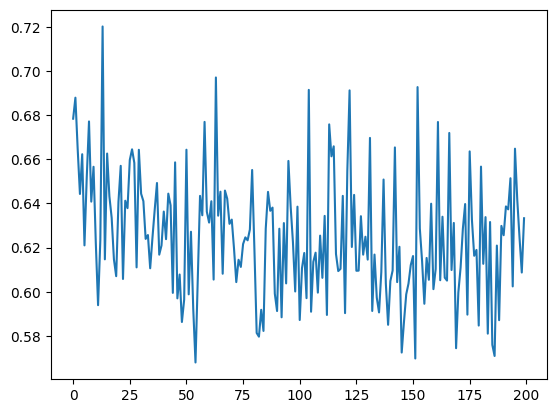

Train Accuracies


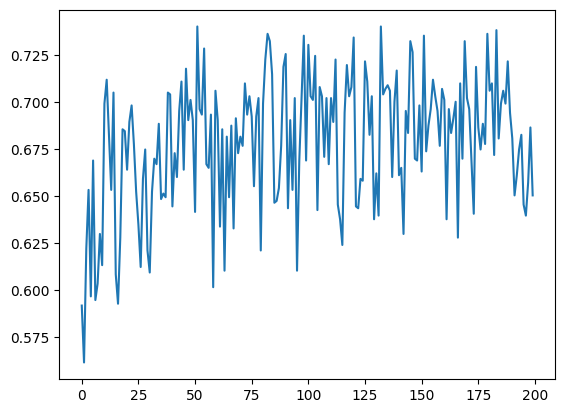

Validation Losses


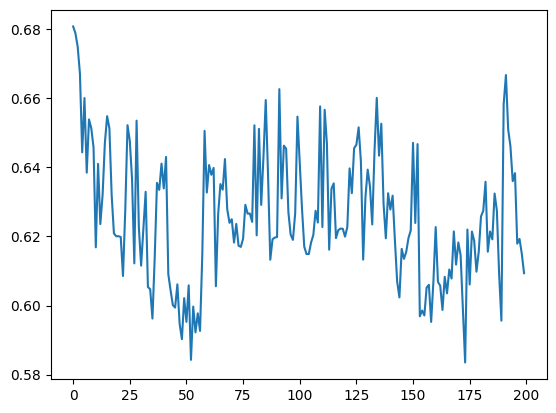

Validation Accuracies


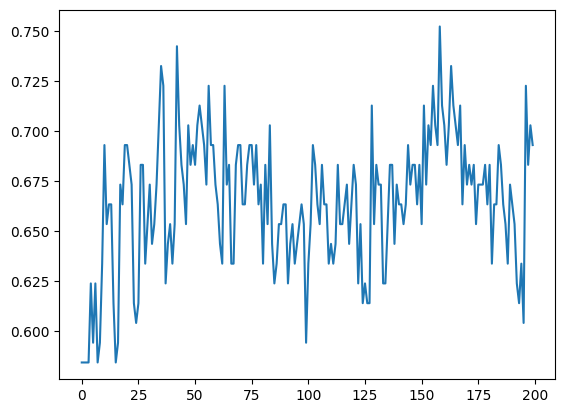

In [9]:
print("Train Losses")
plt.plot(train_losses)
plt.show()
print("Train Accuracies")
plt.plot(train_accuracies)
plt.show()
print("Validation Losses")
plt.plot(val_losses)
plt.show()
print("Validation Accuracies")
plt.plot(val_accuracies)
plt.show()

## Performance on the test set

In [10]:
seed_everything(77)
model.eval()
test_loss = 0.0
test_acc=0.0
for i, data in enumerate(tqdm(test_loader)):
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch)
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        test_acc+=acc
        test_loss += loss.item()

epoch_test_loss=test_loss/len(test_loader) # Average test loss
epoch_test_accuracy=test_acc/len(test_loader) #Average test accuracy
print(f"Test loss epoch {epoch}: ", epoch_test_loss)
print(f"Test accuracy epoch {epoch}: ", epoch_test_accuracy)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.81it/s]

Test loss epoch 199:  0.6162788271903992
Test accuracy epoch 199:  0.6875


## Further Results

We again remind that to have a complete map of all our tests, please look at _experiments.pdf_ in this repository.